# Global terrorist database (GTD): predicting perpetrator groups

## Problem description
"Use attack type, weapons used, description of the attack, etc. to build a model that can predict what group may have been responsible for an incident."

## What is the problem?
### Informal description
We have data about terrorist attacks but we do now know who commited many of them. Our model should tell us who might be behind a new incident.

### Formal description
* Experience: Data about previous terrorist attacks.
* Task: Predict which terrorist group might have been responsible for a new terrorist attacks.
* Performance (baseline): The ratio of correctly predicted terrorist groups.

### Assumptions
* There are clearly defined groups behind the indicent.
* Terrorist groups have a robust and consistent method which does not change significantly.
* Terrorists approach "terror problems" similarly across groups, regions and time periods and therefore the patterns of some terrorist acts can help us to explain others or predict future ones.
* Particular definition of terrorism (see appendixes)
* The information sources and the information itself are valid

### Similar problems
Domain similarity: Other violent but non-terrorist acts

## Why does the problem needs to be solved?
### Motivation
* Violent acts, like terrorism are wrong and should be stopped.
* Better understanding terrorism might help us to also understand the motivation of the perpetrators and the broader circumstances causing them.
* Ideally, we would be able to identify terrorist groups--even if they do not have any incident history in the database yet--which are planning an attact, their location, time and other specifics. We cannot do this based only on this dataset

### Possible benefits
* Having a better picture of the working of terrorist groups
* Identify common patterns among terrorist acts and their perpetrators

### Solution use
* We can estimate better unknown past and future perpetrators.
* Predict and prevent future events from happening.
* Identify organizing principles behind terrorist acts and groups.

## How would I solve the problem without machine learning?
* Ethnographic approach: Interviewing perpetartors and their peers to gain knowledge about the story of their terrorist projects. What were their motivations, what were their aims, what circumstances did they have to follow, what practicalities did they need to attend?
* Macrosociological approach: Examining the actual socio-economic patterns within the region preceding the terrorist acts and the material-technological circumstances with which the perpetrators needed to work with.

# The Data
The project examines the following dataset:
> National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2016). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd

Data is missing for 1993.
```python
gtd.iyear.value_counts().sort_index()
```
Nonetheless, these are also available in a separate file.

## GTD history timeline
* 2001 University of Mariland gains data from Pinkerton about terrorism events from 1970 to 1997 (GTD1)
* 2005 Digitization: corrections and adding information
* April 2006 Funding to extend the data beyond 1997 through 2007 from archival sources and with a different concept of terrorism (GTD2)
* 2008 data collection is finished, applying the new inclusion criteria also on the previous data
* Spring of 2008- Spring of 2012: ISVG collects data betwen April 2008 - October 2011. This is integrated and the existing data is improved.
* 2012 - Data starting with November 2011 is conducted by START,
    - "As a result of these improvements, **a direct comparison between 2011 and 2012 data likely overstates the increase in total attacks and fatalities** worldwide during this time period."
    
in 2014, [other researchers raised issues](https://www.washingtonpost.com/news/monkey-cage/wp/2014/08/11/how-to-fix-the-flaws-in-the-global-terrorism-database-and-why-it-matters/?noredirect=on) about the GTD's failure to make explicit its temporal differences. As of the time of access, the dataset description contains the following warning:

> Users should note that differences in levels of attacks before and after January 1, 1998, before and after April 1, 2008, and before and after January 1, 2012 may be at least partially explained by differences in data collection

## Further specs
- Cases when the **"coder noted some uncertainty whether an incident meets all of the criteria for inclusion ("Doubt Terrorism Proper,")"**
- The GTD includes failed attacs, but does not include foiled or failed plots and violent threats where no action were taken.
- No state terrorims is included.
- Sources range from well-known international news agencies to English translations of local papers written in numerous foreign languages.
- Prior to 2012, identifying a year’s worth of terrorist incidents for inclusion in the GTD typically involved the use of approximately 300 unique news sources. By comparison, the 2012 update is based on a pool of over 1500 unique news sources.

## Criteria for terrorism
Three main criteria of terrorism
- Intentional
- Entails violence (against property/people)
- Sub-national actor

In addition, at least two of the following:
- Provided some social goal (i.e. not only for profit)
- Intention to convey message to the broader public
- Outside humanitarian law

## Similar works

There are a number of publicly available papers describing machine learning projects with the GTD. A few of them aims to predict perpetrator groups, most of them exclusively focusing on incidents in India. They are somehow build upon each other, so I reviewed closely the most two ones. One paper used 'Factor Analysis of Mixed Data' to select attributes for the model, imputed missing values, and used the data between 1990 and 2014 to predict perpetrators of the 2015 incidents. It reported a 73.2% accuracy with SVM <a id='1'> [[1]](#f1) </a>. Another one used data from 1970 and 2015 and--after some feature engineering, cleaning and rebalancing--it used C4.5 (or J48 in WEKA) to correctly classify 98.7936% of the instances with 0.988 F-measure and 0.998 ROC AUC <a id='2'> [[2]](#f2) </a>.

## Importing libraries

## Fundamentals

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

## EDA and preprocessing

In [4]:
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.ensemble import IsolationForest

/home/andras/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
from imblearn.over_sampling import SMOTE

## Cross validation

In [6]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, StratifiedKFold, StratifiedShuffleSplit

## Models

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
#from sklearn.linear_model import LogisticRegression

## Metrics

In [8]:
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import roc_auc_score as auc_score
from sklearn.metrics import accuracy_score, precision_score

## Setting the temp folder
This is required for "jobs=-1" to work on Kaggle at some cases (see https://www.kaggle.com/getting-started/45288#292143)

In [9]:
%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


# Exploratory data analysis

Previously we loaded the data and created a sample out of it. From now on we are going to use it for our analysis and modeling.

In [10]:
# Instead of the excel from their homepage, I use the csv version they uploaded to Kaggle
#gtd = pd.read_excel("globalterrorismdb_0617dist.xlsx")
gtd = pd.read_csv("../input/globalterrorismdb_0617dist.csv", encoding='ISO-8859-1')

FileNotFoundError: File b'../input/globalterrorismdb_0617dist.csv' does not exist

In [9]:
# Because the dataset is highly imbalanced, I tried to get a stratified sample, but was unable to do so.
#stsmp = train_test_split(gtd_ori, train_size=0.25, startify=['gname'])
#stsmp.to_excel("stsmp.xlsx")
# gtd = pd.read_excel("stsmp.xlsx")

smp = gtd.sample(frac=0.25, random_state=4721)
#smp.to_excel("sample.xlsx")
#smp = pd.read_excel("sample.xlsx")

In [10]:
gtd.info(verbose=True, null_counts=True, max_cols=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170350 entries, 0 to 170349
Data columns (total 135 columns):
eventid               170350 non-null int64
iyear                 170350 non-null int64
imonth                170350 non-null int64
iday                  170350 non-null int64
approxdate            7464 non-null object
extended              170350 non-null int64
resolution            2219 non-null object
country               170350 non-null int64
country_txt           170350 non-null object
region                170350 non-null int64
region_txt            170350 non-null object
provstate             155848 non-null object
city                  169904 non-null object
latitude              165744 non-null float64
longitude             165744 non-null float64
specificity           170346 non-null float64
vicinity              170350 non-null int64
location              47974 non-null object
summary               104212 non-null object
crit1                 170350 non-null int64

### Column data types and the number of unique values in them.

We list the unique values of attributes and group them by their datatype:

In [11]:
uniques = gtd.nunique()
types = gtd.dtypes

In [12]:
atts = pd.concat([uniques, types], axis=1)
#atts.rename(columns=['types', 'uniques'], inplace=True)
atts.columns = ['uniques', 'types']

for coltype in atts.types.unique():
    clist = atts[atts.types == coltype].sort_values(by='uniques', ascending=False)
    print("\n{}:\n\n{}\n".format(coltype, clist.uniques))


int64:

eventid        170350
country           205
iyear              46
iday               32
targtype1          22
imonth             13
region             12
weaptype1          12
attacktype1         9
INT_MISC            3
INT_IDEO            3
INT_LOG             3
property            3
INT_ANY             3
doubtterr           3
vicinity            3
suicide             2
success             2
individual          2
crit3               2
crit2               2
crit1               2
extended            2
multiple            2
Name: uniques, dtype: int64


object:

summary               101538
target1                82974
scite1                 75887
scite2                 56562
location               39816
city                   33957
scite3                 32562
corp1                  31299
related                20829
propcomment            18344
weapdetail             18246
addnotes               14150
motive                 13033
target2                 4790
gname             

There are many categorical or even binomial attributes which however contain their own missing value codes which we need to recode later.

## Attribute domain categories

Based on the GTD Codebook (adjusted with own analysis), the dataset consists of the following attribute groups:
1. Time
2. Location
3. Incident
4. Attack
5. Perpetrators
6. Perpetrator validity
7. Weapon
8. Target
9. Casualties and consequences
10. Additional information

In [13]:
att_time = ['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended', 'resolution']
att_loc = ['country', 'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity','vicinity', 'location']
att_incid = ['summary', 'crit1', 'crit2', 'crit3', 'doubtterr', 'alternative', 'alternative_txt', 'multiple', 'related']
att_attack = ['success', 'suicide', 'attacktype1', 'attacktype1_txt', 'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt']
att_perp = ['gname', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3']
att_perval = ['motive', 'guncertain1', 'guncertain2', 'guncertain3', 'individual', 'nperps', 'nperpcap', 'claimed', 'claimmode', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 'claim3', 'claimmode3', 'claimmode3_txt', 'compclaim']
att_weap = ['weaptype1', 'weaptype1_txt', 'weapsubtype1', 'weapsubtype1_txt', 'weaptype2', 'weaptype2_txt', 'weapsubtype2', 'weapsubtype2_txt', 'weaptype3', 'weaptype3_txt', 'weapsubtype3', 'weapsubtype3_txt', 'weaptype4', 'weaptype4_txt', 'weapsubtype4', 'weapsubtype4_txt', 'weapdetail']
att_targ = ['targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt', 'targtype2', 'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2', 'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt', 'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3', 'natlty3_txt']
att_cons = ['nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property', 'propextent', 'propextent_txt', 'propvalue', 'propcomment', 'ishostkid', 'nhostkid', 'nhostkidus', 'nhours', 'ndays', 'divert', 'kidhijcountry', 'ransom', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus', 'ransomnote', 'hostkidoutcome', 'hostkidoutcome_txt', 'nreleased']
att_info = ['addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY',]

In [14]:
colgrps = {'att_time' : ['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended', 'resolution'],
           'att_loc' : ['country', 'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity','vicinity', 'location'],
           'att_incid' : ['summary', 'crit1', 'crit2', 'crit3', 'doubtterr', 'alternative', 'alternative_txt', 'multiple', 'related'],
           'att_attack' : ['success', 'suicide', 'attacktype1', 'attacktype1_txt', 'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt'],
           'att_perp' : ['gname', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3'],
           'att_perval' : ['motive', 'guncertain1', 'guncertain2', 'guncertain3', 'individual', 'nperps', 'nperpcap', 'claimed', 'claimmode', 'claimmode_txt', 'claim2', 'claimmode2', 'claimmode2_txt', 'claim3', 'claimmode3', 'claimmode3_txt', 'compclaim'],
           'att_weap' : ['weaptype1', 'weaptype1_txt', 'weapsubtype1', 'weapsubtype1_txt', 'weaptype2', 'weaptype2_txt', 'weapsubtype2', 'weapsubtype2_txt', 'weaptype3', 'weaptype3_txt', 'weapsubtype3', 'weapsubtype3_txt', 'weaptype4', 'weaptype4_txt', 'weapsubtype4', 'weapsubtype4_txt', 'weapdetail'],
           'att_targ' : ['targtype1', 'targtype1_txt', 'targsubtype1', 'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt', 'targtype2', 'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2', 'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt', 'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3', 'natlty3_txt'],
           'att_cons' : ['nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property', 'propextent', 'propextent_txt', 'propvalue', 'propcomment', 'ishostkid', 'nhostkid', 'nhostkidus', 'nhours', 'ndays', 'divert', 'kidhijcountry', 'ransom', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus', 'ransomnote', 'hostkidoutcome', 'hostkidoutcome_txt', 'nreleased'],
           'att_info' : ['addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY',]}

### From among these, the 'att_perp' group contains the target variable(s).

## Perpetrator names

In [15]:
gtd[colgrps['att_perp']]

,gname,gsubname,gname2,gsubname2,gname3,gsubname3
0,MANO-D,NaN,NaN,NaN,NaN,NaN
1,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN
2,Unknown,NaN,NaN,NaN,NaN,NaN
3,Unknown,NaN,NaN,NaN,NaN,NaN
4,Unknown,NaN,NaN,NaN,NaN,NaN
5,Black Nationalists,NaN,NaN,NaN,NaN,NaN
6,Tupamaros (Uruguay),NaN,NaN,NaN,NaN,NaN
7,Unknown,NaN,NaN,NaN,NaN,NaN
8,New Year's Gang,NaN,NaN,NaN,NaN,NaN
9,New Year's Gang,NaN,NaN,NaN,NaN,NaN


### Number of incidents per groups

More than 45% of the  perpetrators are unknown:

In [16]:
gtd.gname.value_counts(normalize=True).head(1)

Unknown    0.459677
Name: gname, dtype: float64

In [17]:
known = gtd[gtd.gname != 'Unknown']

###  Distribution of incidents among groups

In [18]:
inc_grp = known.gname.value_counts()

In [19]:
print(inc_grp)

Taliban                                                     6575
Shining Path (SL)                                           4551
Islamic State of Iraq and the Levant (ISIL)                 4287
Farabundo Marti National Liberation Front (FMLN)            3351
Al-Shabaab                                                  2683
Irish Republican Army (IRA)                                 2669
Revolutionary Armed Forces of Colombia (FARC)               2481
New People's Army (NPA)                                     2414
Kurdistan Workers' Party (PKK)                              2152
Boko Haram                                                  2077
Basque Fatherland and Freedom (ETA)                         2024
Communist Party of India - Maoist (CPI-Maoist)              1766
Liberation Tigers of Tamil Eelam (LTTE)                     1606
National Liberation Army of Colombia (ELN)                  1483
Maoists                                                     1424
Tehrik-i-Taliban Pakistan

The proportion of recognized groups responsible only for a single incident:

In [20]:
len(inc_grp[inc_grp == 1]) / len(known)

0.018393377080526706

The cumulative distribution of incidents among the known groups:

In [21]:
inc_grp_csum = known.gname.value_counts(normalize=True).cumsum()
inc_grp_csum

Taliban                                                     0.071433
Shining Path (SL)                                           0.120877
Islamic State of Iraq and the Levant (ISIL)                 0.167453
Farabundo Marti National Liberation Front (FMLN)            0.203859
Al-Shabaab                                                  0.233008
Irish Republican Army (IRA)                                 0.262005
Revolutionary Armed Forces of Colombia (FARC)               0.288960
New People's Army (NPA)                                     0.315186
Kurdistan Workers' Party (PKK)                              0.338566
Boko Haram                                                  0.361132
Basque Fatherland and Freedom (ETA)                         0.383121
Communist Party of India - Maoist (CPI-Maoist)              0.402308
Liberation Tigers of Tamil Eelam (LTTE)                     0.419756
National Liberation Army of Colombia (ELN)                  0.435868
Maoists                           

Around a fifth  of the groups is responsible for 90% of all _known_ incidents, and 40% for 95%.

In [22]:
len(inc_grp_csum[inc_grp_csum <= 0.90]) / len(gtd.gname.unique())

0.1007527504342791

In [23]:
len(inc_grp_csum[inc_grp_csum <= 0.95]) / len(gtd.gname.unique())

0.22379849449913145

In [24]:
len(inc_grp_csum[inc_grp_csum <= 0.99]) / len(gtd.gname.unique())

0.7330631152287204

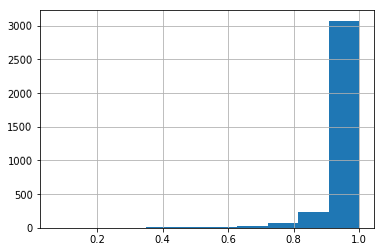

In [25]:
inc_grp_csum.T.hist(yrot=True)

### Second and third groups

The database also records second and third groups but only for around 1% of the total incidents:

In [26]:
names = known.loc[:, ['gname', 'gname2', 'gname3']]

In [27]:
names.count() / len(known)

gname     1.000000
gname2    0.018904
gname3    0.002923
dtype: float64

In [28]:
names.apply(lambda x: x.value_counts(dropna=False)).sort_values(by='gname', ascending=False)

,gname,gname2,gname3
Taliban,6575.0,30.0,2.0
Shining Path (SL),4551.0,1.0,NaN
Islamic State of Iraq and the Levant (ISIL),4287.0,42.0,14.0
Farabundo Marti National Liberation Front (FMLN),3351.0,NaN,NaN
Al-Shabaab,2683.0,6.0,NaN
Irish Republican Army (IRA),2669.0,NaN,NaN
Revolutionary Armed Forces of Colombia (FARC),2481.0,24.0,NaN
New People's Army (NPA),2414.0,7.0,NaN
Kurdistan Workers' Party (PKK),2152.0,19.0,NaN
Boko Haram,2077.0,12.0,1.0


### Subnames

The database also records subnames for perpetrators for around 3% of the perpetrators.

In [29]:
sub_names = gtd.loc[:,['gsubname', 'gsubname2', 'gsubname3']].dropna(how='all').groupby(by=gtd.loc[:,'gname']).count()

In [30]:
sub_names.sum() / len(gtd)

gsubname     0.030473
gsubname2    0.000875
gsubname3    0.000076
dtype: float64

In [31]:
sub_names.sort_values(by='gsubname', ascending=False)

,gsubname,gsubname2,gsubname3
gname,,,
Farabundo Marti National Liberation Front (FMLN),526,0,0
Sikh Extremists,412,0,0
Revolutionary Armed Forces of Colombia (FARC),399,7,0
New People's Army (NPA),241,0,0
Islamic State of Iraq and the Levant (ISIL),224,15,0
Tehrik-i-Taliban Pakistan (TTP),159,3,1
Tamils,147,0,0
Kurdistan Workers' Party (PKK),141,2,0
Hezbollah,117,0,0


### Suspected perpetrators

Around 15% of perpetrator information is in a 'suspected' status.

In [32]:
guncertcols = gtd.loc[:, ['guncertain1','guncertain2','guncertain3']]

In [33]:
guncertcols[guncertcols == 1].dropna(how='all').count() / len(known)

guncertain1    0.155773
guncertain2    0.004835
guncertain3    0.000532
dtype: float64

On the other hand, the coding book is not clear about what exactly the '1' of 'uncertainty' value means compared to the '0' and 'NaN' values.

In [34]:
guncertcols.apply(lambda x: x.value_counts(dropna=False))

,guncertain1,guncertain2,guncertain3
0.0,155633,1236,216
1.0,14338,445,49
NaN,379,168669,170085


### Unaffiliated individuals

The ratio of 'unaffiliated' individuals (i.e. individuals who were recognised but were not affiliated to known groups) is 0.26%.

In [35]:
gtd.individual.value_counts().iloc[1] / len(gtd)

0.0024831229820956855

Where the perpetrator is an unaffiliated individual it is somehow also connected to a vague, broadly defined group:

In [36]:
gtd.gname[(gtd.individual == 1) & (gtd.gname != "Unknown")].value_counts()

Jihadi-inspired extremists       64
Anti-Government extremists       34
White extremists                 30
Anti-Abortion extremists         28
Anti-Muslim extremists           24
Muslim extremists                23
Anti-Semitic extremists          16
Anti-Technology extremists       14
Anti-Police extremists           10
Anti-Nuclear extremists           8
Right-wing extremists             5
Marxists                          4
Iraqi extremists                  4
Anti-Gun Control extremists       3
Anti-Immigrant extremists         3
Anti-Israeli extremists           2
Environmentalists                 2
Neo-Nazi extremists               2
Anti-United States extremists     2
Turkish radicals                  2
Iranian extremists                2
Anti-White extremists             2
Animal Rights extremists          2
Anarchists                        1
Egyptians                         1
Supporters of Charles Manson      1
Armenian extremists               1
Albanian extremists         

## Summary of perpetrator information analysis
Because of the relative low coverage, we will not try to predict second/third perpetrators and subnames. Later on, the process might be enhanced to become able to do so.

## Special attributes
The data set also contains a number of special attributes, from among which we drop the `eventid` column, `addnotes` and the information about the record's data source:
* eventid
* addnotes
* scite1
* scite2
* scite3
* dbsource



In [37]:
temp = gtd.drop(['eventid', 'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource'], axis=1, errors='ignore')

## Missing values

### Recoding built-in missing values

The `miscodes` dictionary defines the attribute-missing value code pairs:

In [38]:
miscodes = {"0": ['imonth', 'iday'], 
            "-9": ['claim2', 'claimed', 'compclaim', 'doubtterr', 'INT_ANY', 'INT_IDEO', 'INT_LOG', 'INT_MISC', 
                   'ishostkid', 'ndays', 'nhostkid', 'nhostkidus', 'nhours', 'nperpcap', 'nperps', 'nreleased', 
                   'property', 'ransom', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus', 'vicinity'], 
            "-99": ['ransompaid', 'nperpcap', 'compclaim', 'nreleased', 'nperps', 'nhostkidus', 'ransomamtus', 
                    'ransomamt', 'nhours', 'ndays', 'propvalue', 'ransompaidus', 'nhostkid']}

In [39]:
temp[miscodes['0']].apply(lambda x: x.value_counts())

,imonth,iday
0,20.0,891
1,14036.0,6020
2,12975.0,5590
3,14284.0,5679
4,14213.0,5818
5,15771.0,5498
6,14258.0,5422
7,15247.0,5598
8,14802.0,5501
9,13246.0,5693


In [40]:
temp[miscodes['-9']].apply(lambda x: x.value_counts())

,claim2,claimed,compclaim,doubtterr,INT_ANY,INT_IDEO,INT_LOG,INT_MISC,ishostkid,ndays,...,nperpcap,nperps,nreleased,property,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,vicinity
-9.900000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3810.0,...,1642.0,73051.0,3143.0,NaN,NaN,231.0,23.0,291.0,23.0,NaN
-9.000000e+00,16.0,1474.0,3433.0,13786.0,79093.0,87629.0,87497.0,487.0,269.0,NaN,...,4.0,2.0,NaN,19579.0,1358.0,3.0,NaN,1.0,1.0,36.0
0.000000e+00,1073.0,86578.0,958.0,129942.0,56583.0,62433.0,76160.0,149964.0,157411.0,225.0,...,95558.0,139.0,2018.0,60752.0,73726.0,339.0,447.0,234.0,457.0,158442.0
2.500000e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.000000e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.000000e+00,528.0,16164.0,364.0,26622.0,34674.0,20288.0,6693.0,19899.0,12492.0,739.0,...,1723.0,7517.0,1926.0,90019.0,1229.0,2.0,NaN,NaN,NaN,11872.0
2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,405.0,...,723.0,5611.0,616.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2.500000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.0,...,372.0,2626.0,350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196.0,...,255.0,2084.0,239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
temp[miscodes['-99']].apply(lambda x: x.value_counts())

,ransompaid,nperpcap,compclaim,nreleased,nperps,nhostkidus,ransomamtus,ransomamt,nhours,ndays,propvalue,ransompaidus,nhostkid
-9.900000e+01,291.0,1642.0,NaN,3143.0,73051.0,60.0,23.0,231.0,1791.0,3810.0,25139.0,23.0,1134.0
-9.000000e+00,1.0,4.0,3433.0,NaN,2.0,NaN,NaN,3.0,11.0,NaN,NaN,1.0,NaN
0.000000e+00,234.0,95558.0,958.0,2018.0,139.0,12005.0,447.0,339.0,1293.0,225.0,194.0,457.0,6.0
2.500000e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
5.000000e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1.000000e+00,NaN,1723.0,364.0,1926.0,7517.0,249.0,NaN,2.0,184.0,739.0,2.0,NaN,5073.0
2.000000e+00,1.0,723.0,NaN,616.0,5611.0,54.0,NaN,NaN,101.0,405.0,NaN,NaN,1690.0
2.500000e+00,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.000000e+00,NaN,372.0,NaN,350.0,2626.0,23.0,NaN,NaN,61.0,292.0,1.0,NaN,945.0
4.000000e+00,NaN,255.0,NaN,239.0,2084.0,13.0,NaN,NaN,43.0,196.0,NaN,NaN,676.0


We transform these missing value codes into numpy `NaN` values

In [42]:
def mistonan(data, collist, nancode):
    """Replaces columns' missing value code with numpy NaN.

        Parameters:
        `data`: dataframe

        `nanvalue` : the code of the missing value in the columns
        """
    colstonan = []

    for col in collist:
        if col in data.columns:
            colstonan.append(col)
        else:
            print("'{}' is not among the dataframe's columns.".format(col))

    data[colstonan] = data[colstonan].apply(lambda x: x.replace(nancode, np.NaN))

In [43]:
for key in miscodes.keys():
    mistonan(temp, miscodes[key], float(key))

We also replace "Unknown" values with numpy `NaN`s whenever it occurs except in the `gname` target attribute (which we do separately, when needed).

In [44]:
temp.drop(columns='gname').replace(to_replace='Unknown', value=np.NaN, inplace=True)

### Missing value ratios

In [45]:
def missing_ratio(data):
    """
    Lists missing values ratios for each column in a dataset.
    
    Takes `data`, dataset.
    
    Returns the `mrat` dataframe, which lists the columns and their corresponding missing value ratios in descending order.
    """
    mrat = data.isna().mean()[data.isna().any()== True].sort_values()
    
    return mrat

In [46]:
misrat = missing_ratio(temp)

From among the total 135 attributes 104 contains missing values. 96 of them has a 95% missing value rate:

In [47]:
misrat[misrat > 0.05].count()

96

In [48]:
misrat

specificity         0.000023
imonth              0.000117
vicinity            0.000211
guncertain1         0.002225
city                0.002618
ishostkid           0.002624
INT_MISC            0.002859
target1             0.003733
iday                0.005230
natlty1_txt         0.008183
natlty1             0.008183
latitude            0.027038
longitude           0.027038
targsubtype1_txt    0.054858
targsubtype1        0.054858
nkill               0.056836
doubtterr           0.080928
provstate           0.085131
nwound              0.089962
weapsubtype1        0.114036
weapsubtype1_txt    0.114036
property            0.114934
corp1               0.249874
weapdetail          0.348606
nkillus             0.378392
nwoundus            0.379865
summary             0.388248
nkillter            0.391330
claimed             0.396877
nwoundte            0.403575
                      ...   
compclaim           0.992240
ransomamt           0.993866
targtype3_txt       0.993930
targtype3     

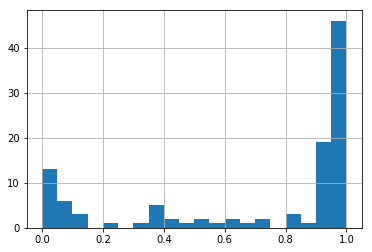

In [49]:
misrat.hist(bins=20)

## Outliers

In [50]:
idx_gtd = temp.dtypes[(temp.dtypes == 'float64') |
              (temp.dtypes == 'int64')].index                                   

nums = temp.reindex(idx_gtd, axis=1)
#nums.drop(['eventid'], axis=1, inplace=True)

iyear                AxesSubplot(0.125,0.855645;0.133621x0.0243548)
imonth            AxesSubplot(0.285345,0.855645;0.133621x0.0243548)
iday               AxesSubplot(0.44569,0.855645;0.133621x0.0243548)
extended          AxesSubplot(0.606034,0.855645;0.133621x0.0243548)
country           AxesSubplot(0.766379,0.855645;0.133621x0.0243548)
region               AxesSubplot(0.125,0.826419;0.133621x0.0243548)
latitude          AxesSubplot(0.285345,0.826419;0.133621x0.0243548)
longitude          AxesSubplot(0.44569,0.826419;0.133621x0.0243548)
specificity       AxesSubplot(0.606034,0.826419;0.133621x0.0243548)
vicinity          AxesSubplot(0.766379,0.826419;0.133621x0.0243548)
crit1                AxesSubplot(0.125,0.797194;0.133621x0.0243548)
crit2             AxesSubplot(0.285345,0.797194;0.133621x0.0243548)
crit3              AxesSubplot(0.44569,0.797194;0.133621x0.0243548)
doubtterr         AxesSubplot(0.606034,0.797194;0.133621x0.0243548)
alternative       AxesSubplot(0.766379,0.797194;

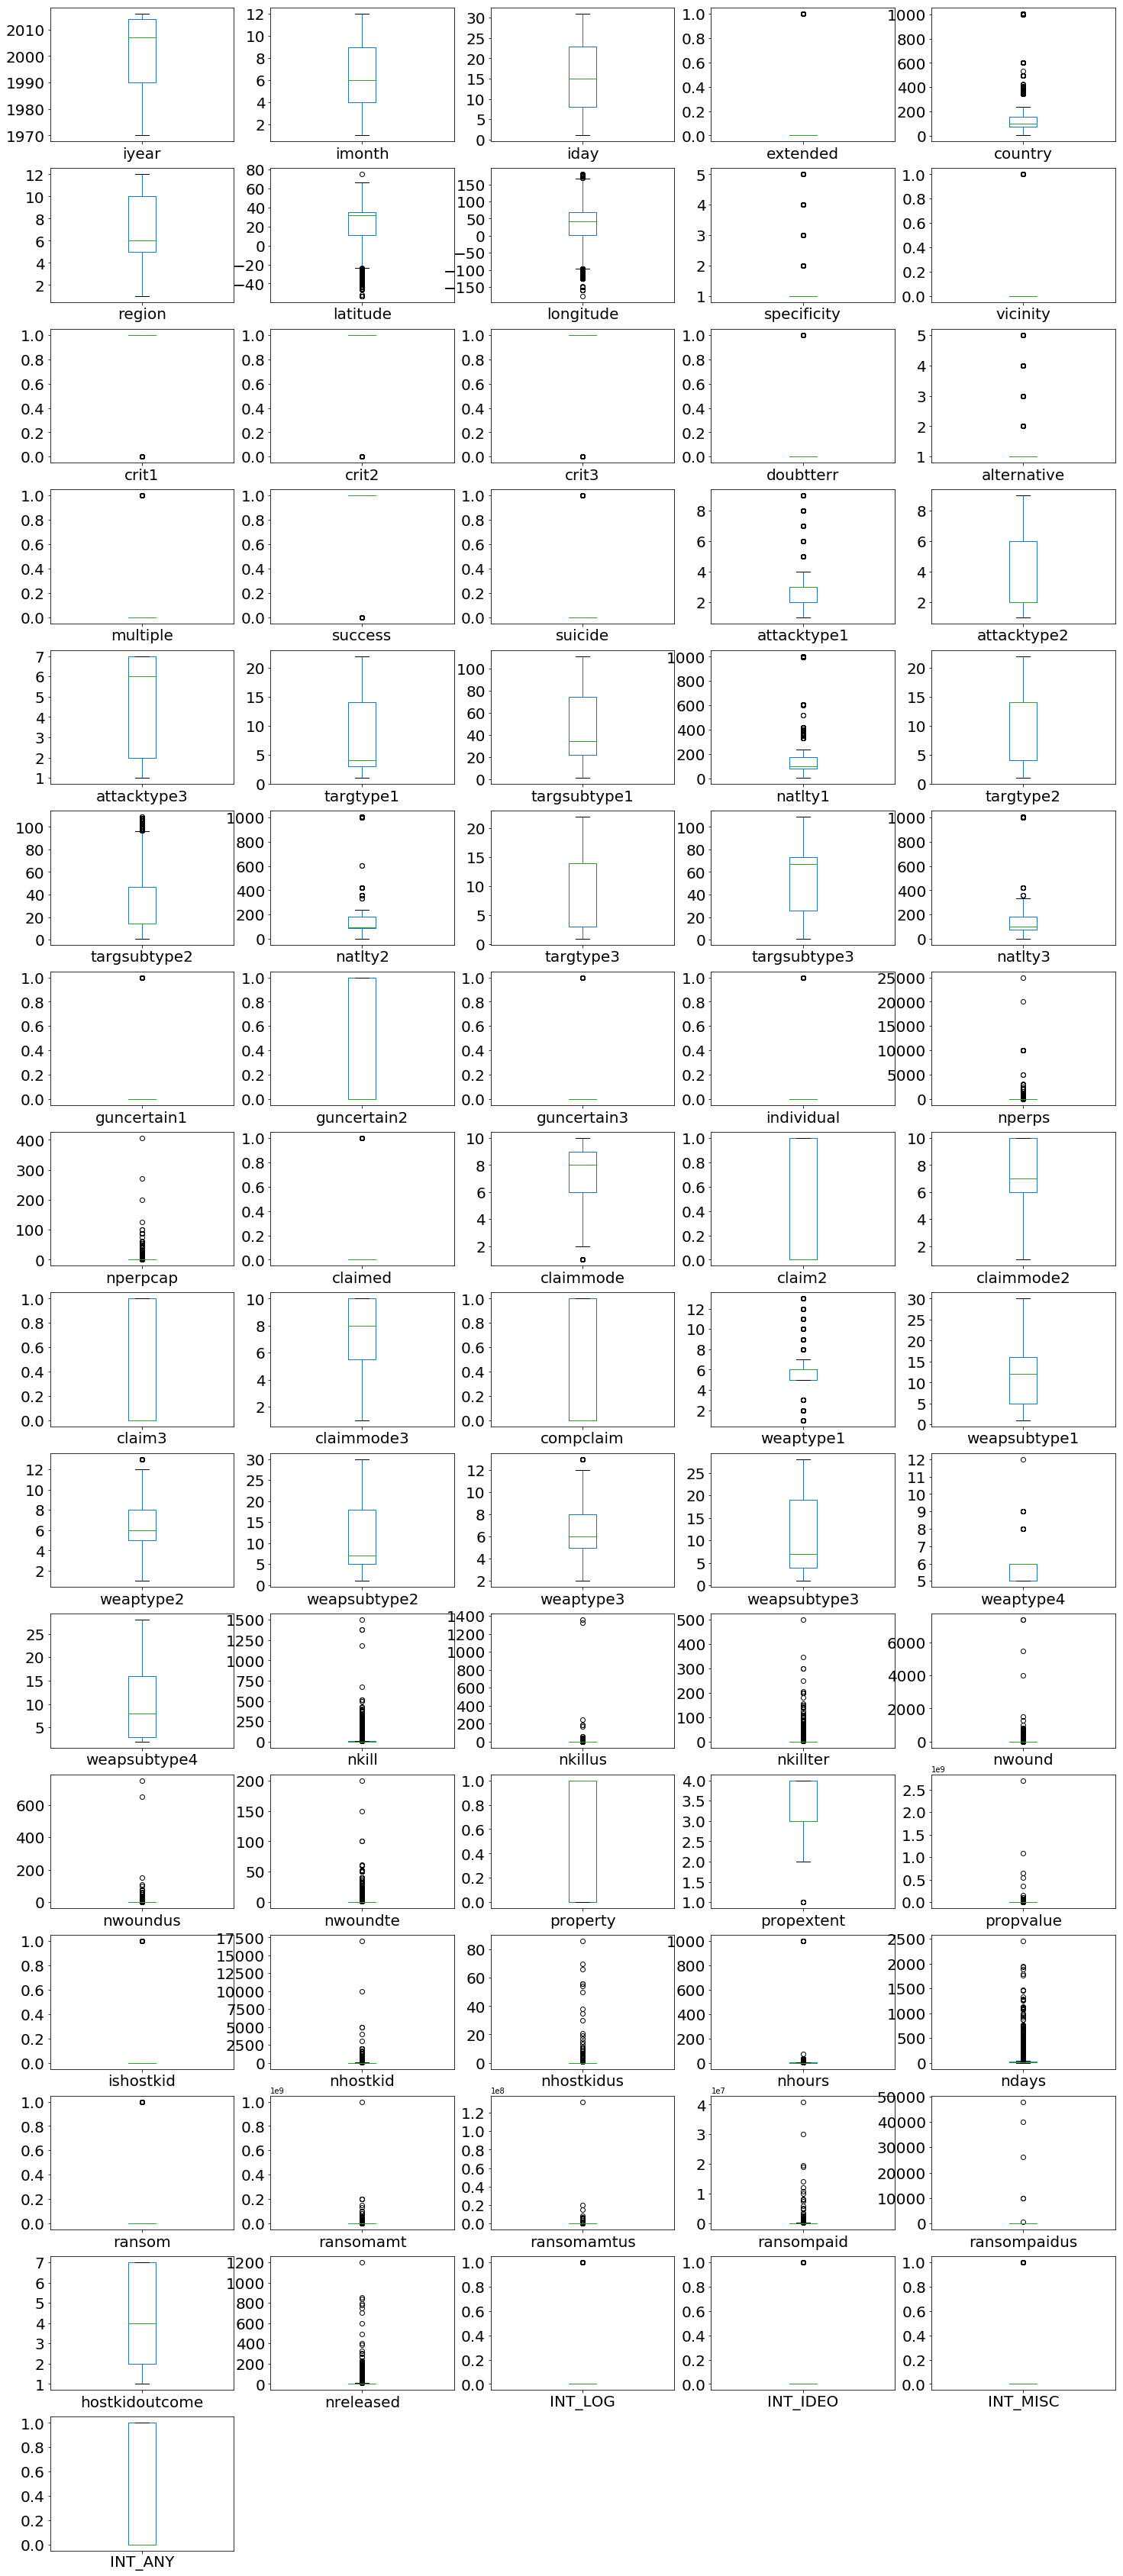

In [51]:
nums.plot(kind='box', subplots=True, layout=(26,5), figsize=(25, 100), fontsize=20)

The dataset is imbalanced by many attributes. The visually recognisable examples:
* `iyear`
* `region`
* `attacktype` series
* `targtype` and `targsubtype` series
* `claimmode`
* `weapontype` and `weaponsubtype`

Because this is a highly imbalanced dataset we use the `IsolationForest` model to define outliers.

We drop missing values:

In [52]:
nums.dropna(axis=1, inplace=True, thresh=nums.shape[0] * 0.95)
nums.dropna(inplace=True)

In [53]:
clf = IsolationForest(max_samples='auto', random_state=153, contamination=0.05, verbose=True, n_jobs=-1)

In [54]:
clf.fit(nums)
isof = clf.predict(nums)

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.3s finished
/home/andras/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [55]:
isofdf = pd.Series(isof)
nums['Outlier'] = isof

In [56]:
nums = nums[nums.Outlier != -1]
nums.drop(columns='Outlier', inplace=True)

iyear             AxesSubplot(0.125,0.855645;0.133621x0.0243548)
imonth         AxesSubplot(0.285345,0.855645;0.133621x0.0243548)
iday            AxesSubplot(0.44569,0.855645;0.133621x0.0243548)
extended       AxesSubplot(0.606034,0.855645;0.133621x0.0243548)
country        AxesSubplot(0.766379,0.855645;0.133621x0.0243548)
region            AxesSubplot(0.125,0.826419;0.133621x0.0243548)
latitude       AxesSubplot(0.285345,0.826419;0.133621x0.0243548)
longitude       AxesSubplot(0.44569,0.826419;0.133621x0.0243548)
specificity    AxesSubplot(0.606034,0.826419;0.133621x0.0243548)
vicinity       AxesSubplot(0.766379,0.826419;0.133621x0.0243548)
crit1             AxesSubplot(0.125,0.797194;0.133621x0.0243548)
crit2          AxesSubplot(0.285345,0.797194;0.133621x0.0243548)
crit3           AxesSubplot(0.44569,0.797194;0.133621x0.0243548)
multiple       AxesSubplot(0.606034,0.797194;0.133621x0.0243548)
success        AxesSubplot(0.766379,0.797194;0.133621x0.0243548)
suicide           AxesSub

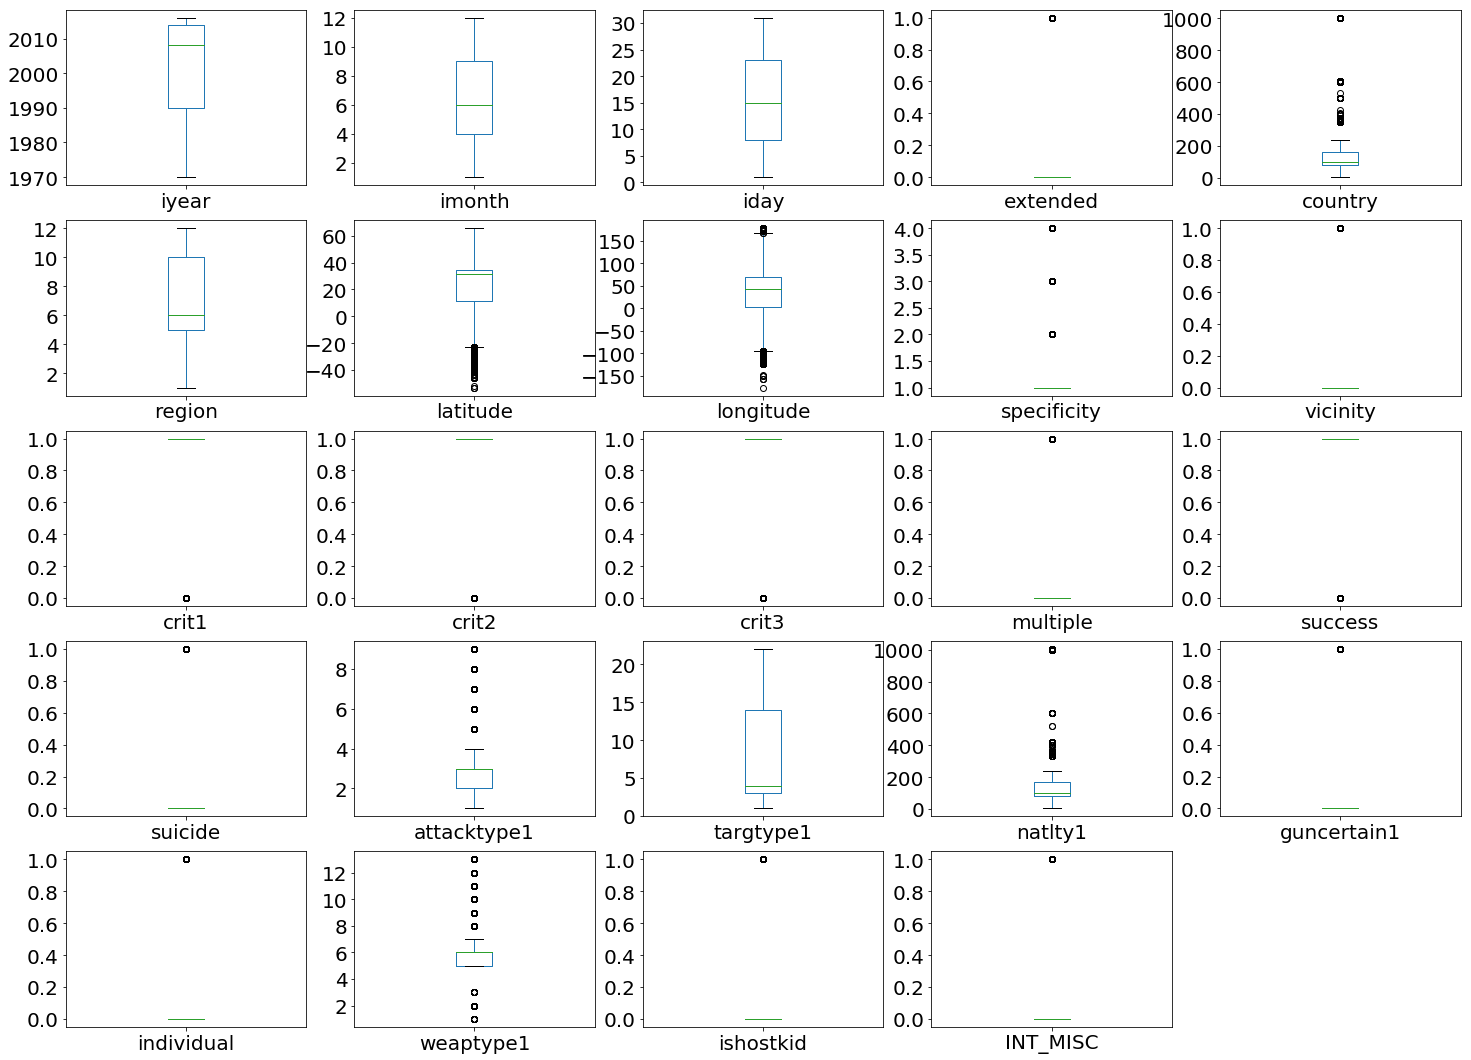

In [57]:
nums.plot(kind='box', subplots=True, layout=(26,5), figsize=(25, 100), fontsize=20)

# Data preprocessing

From among the recognised transformation possibilities, the following transformations are 'universal' (that is, could be used for the whole dataset regardless of the particular training/test split method):
* Remove special attributes
* Recode built-in missing attributes into numpy NaNs

There are a number of configuration possibilites which we also could use but now we leave untouched:

* Exclude uncertain cases.
* Include data only for a selected period.
* Include perpetrators only abouve a particular contribution threshold.

Finally, in the current process we use the following setting:
* Exclude incidents with 'unknown' perpetrators
* Include only general names and only of the primary perpetrators (i.e. `gname`)
* Drop missing values
* Drop outliers
* Include only numerical values
* Exclude 'unaffiliated' individuals.
* Exclude the `resolution` NaTType attribute

## Preprocessing

We summarized the following configuration possibilities in a function:

In [58]:
def preproc(data, 
            primonly=True, 
            period=(1, 5), 
            onlyknown=True, 
            nocat=True, 
            maxna=0.05,
            outrat=0.05,
            topincrat=1, 
            hideind=True, 
            hideuncert=False, 
            dropspec=True,
            dropres=True,
            miscodetonan=True):
    """
    Cleans and preprocesses dataset.
    
    Parameters:
    ===========
    
    `primonly`: boolean, True
    Includes only general perpetrator group names and only of the primary perpetrator (`gname`).
    
    `period`: tuple, (1, 5)
    Defines the included period by setting the start and end dates:
        '1': 1970
        '2': 1998
        '3': April 1 2008
        '4': 2012
        `5`: 2016
    
    `onlyknown`: boolean, True
    Shows only incidents where the perpetrators is identified (even if with doubt).
    
    `nocat`: boolean, True
    Excludes all categorical attributes from the dataset with the exception of the perpetrator group name
    attributes (`gname`:`gsubname3`).
    
    `maxna`: float, 0.05
    The maximum allowed proportion of missing values within an attribute. Drops all rows with missing values and
    keeps only columns with missing value ratio below the given threshold.
    For instance, a value of '0.05' means that only columns with less than 5% of missing values are kept in the dataset.
    
    `outrat`: float, 0.05
    The contamination ratio determining the percent of values classified as outliers and dropped from the dataset.
    The function uses Isolation Forest Tree to identify outliers.
    Prerequisities:
        * No categorical values (`nocat`)
        * No missing values (`maxna`)
    Example: '0.05' means that 5% of values will be flagged as an outlier and dropped.
    
    `topincrat`: float, 1
    Filters perpetrators based on their overall weight of contribution (in terms of number of incidents).
    The parameter's value is the ratio of total incidents for which the selected perpetrators are responsible.
    Perpetrators are ranked based on the number of incidents in which they are involved and the function calculates
    their cumulative contribution. It then makes the selection at or right above the given threshold.
    Example: '0.95' means selecting the perpetator groups with the highest incident ratio responsible together
    for 95% of the total incidents.
    
    `hideind`: boolean, True
    Hides individual perpetrators unaffiliated to groups.
    
    `hideuncert`: boolean, False
    Hides uncertain cases
        
    `dropspec`: boolean, True
    Drops special attributes.
    
    `dropres`: boolean, True
    Drops the `resolution` NaTType attribute.
    
    `miscodetonan`: boolean, True
    Transforms the original codes for missing values into numpy NaN.
    """
    procd = data.copy(deep=True)
    
    # `dropspec`: Drop special attributes
    if dropspec == True:
        procd.drop(['eventid', 'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource'], axis=1, inplace=True)

    # `miscodetonan`: Turn built-in missing codes into numpy NaN
    if miscodetonan == True:
        # The `miscodes` dictionary defines the attribute-missing value code pairs:
        miscodes = {"0": ['imonth', 'iday'], 
                    "-9": ['claim2', 'claimed', 'compclaim', 'doubtterr', 'INT_ANY', 'INT_IDEO', 'INT_LOG', 'INT_MISC', 
                           'ishostkid', 'ndays', 'nhostkid', 'nhostkidus', 'nhours', 'nperpcap', 'nperps', 'nreleased', 
                           'property', 'ransom', 'ransomamt', 'ransomamtus', 'ransompaid', 'ransompaidus', 'vicinity'], 
                    "-99": ['ransompaid', 'nperpcap', 'compclaim', 'nreleased', 'nperps', 'nhostkidus', 'ransomamtus', 
                            'ransomamt', 'nhours', 'ndays', 'propvalue', 'ransompaidus', 'nhostkid']}

        def mistonan(data, collist, nancode):
            """Replaces columns' missing value code with numpy NaN.

            Parameters:
            `data`: dataframe

            `nanvalue` : the code of the missing value in the columns
            """
            colstonan = []

            for col in collist:
                if col in data.columns:
                    colstonan.append(col)
                else:
                    print("'{}' is not among the dataframe's columns.".format(col))
            
            data[colstonan] = data[colstonan].apply(lambda x: x.replace(nancode, np.NaN))

        for key in miscodes.keys():
            mistonan(procd, miscodes[key], float(key))
        
        # Replaces "Unknown" values whenever it occurs except in the `gname` target attribute.
        # The function controls it by the `onlyknown` parameter.
        procd.drop(columns='gname').replace(to_replace='Unknown', value=np.NaN, inplace=True)
    
    # Replacing missing values
    
    ## Replace unknown, '0' days and months with a random value
    ### Months
    #tm = procd.imonth[procd.imonth == 0]
    #tm = tm.apply(lambda x: np.random.randint(1, 13))
    #procd.imonth[procd.imonth == 0] = tm

    ### Days
    #td = procd.iday[procd.iday == 0]
    #td = td.apply(lambda x: np.random. randint(1, 29))
    #procd.iday[procd.iday == 0] = td
    
    # `period`: Filter the dataset for the choosen time period
    dates = [1970, 1997, 2008, 2012, 2016]
    
    predmin = dates[period[0]-1]
    predmax = dates[period[1]-1]
    
    if predmin == 2008:
        procd = procd[((procd.iyear > predmin ) & (procd.iyear < predmax + 1)) | 
                      ((procd.iyear == predmin) & (procd.imonth >= 3))]
    elif predmax == 2008:
        procd = procd[((procd.iyear >= predmin ) & (procd.iyear < predmax)) | 
                      ((procd.iyear == predmax) & (procd.imonth < 3))]
    else:
        procd = procd[(procd.iyear >= predmin) & (procd.iyear < predmax + 1)]
    
    # `onlyknown`: Show only known perpetrators
    if onlyknown == True:
        procd = procd[procd.gname != 'Unknown']
    
    # `hideind`: Hide unaffiliated individuals
    if hideind == True:
        procd = procd[procd.individual != 1]
    
    # `primonly`: Include only the primary perpetrator groups and only their main names.
    if primonly == True:
        procd.drop(columns=['gsubname','gname2','gsubname2','gname3','gsubname3'], axis=1, inplace=True)
    
    # `topincrat`: Set the threshold for the top frequent perpetrators to show.
    tempname = procd.gname
    idx_main_groups = tempname.value_counts()[tempname.value_counts(normalize=True).cumsum() <= topincrat].index
    procd = procd[procd.gname.isin(idx_main_groups)]
    
    # `hideuncert`: Hide uncertain cases
    if hideuncert == True:
        procd = procd[(procd.guncertain1 != 1) |
                      (procd.guncertain2 != 1) |
                      (procd.guncertain3 != 1)]
    
    # `nocat`: Dropping polynomial attributes (except `gname`)
    if nocat == True:
        idx_nonobj = procd.dtypes[(procd.dtypes.index.isin(['gname',
                                                            'gsubname',
                                                            'gname2',
                                                            'gsubname2',
                                                            'gname3',
                                                            'gsubname3'])) |
                                   (procd.dtypes != 'object')].index
                                   
        procd = procd.reindex(idx_nonobj, axis=1)

    # `dropres`: Drop the `resolution` attribute
    if dropres == True:
        procd.drop(columns='resolution', inplace=True, errors='ignore')
        
    #print(procd)
    
    # `maxna`: Drop missing values and columns with missing values above the threshold.
    procd.dropna(axis=1, inplace=True, thresh=procd.shape[0] * (1 - maxna))
    procd.dropna(inplace=True)
    
    # `outrat`: Drop outliers
    clf = IsolationForest(max_samples='auto', random_state=2425, contamination=outrat, verbose=True, n_jobs=-1)
    
    clf.fit(procd.drop(columns='gname'))
    isof = clf.predict(procd.drop(columns='gname'))

    isofdf = pd.Series(isof)
    procd['Outlier'] = isof

    procd = procd[procd.Outlier != -1]
    procd.drop(columns='Outlier', inplace=True)
    
    # Drop correlated values
    #procd = dropcors(procd, corthr)

    print(procd.info(verbose=True))
    return procd

Finally we are going to train the model on the following way:
* Only known perpetrators and only perpetrator groups
* Only examining the main names of the 'first' perpetrators
* For the whole time period
* Dropping attributes:
    * with more the 5% of missing values
    * with non-numerical values
    * `resolution`
* Dropping 5% of outlier values

In [59]:
# moddat = gtd.copy(deep=True)
moddat = smp.copy(deep=True)
moddat = preproc(moddat, 
                 primonly=True, 
                 period=(1, 5), 
                 onlyknown=True, 
                 nocat=True, 
                 maxna=0.05, 
                 outrat=0.05,
                 topincrat=1, 
                 hideind=True, 
                 hideuncert=False, 
                 dropspec=True,
                 dropres=True,
                 miscodetonan=True)

[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished
/home/andras/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19012 entries, 111973 to 69569
Data columns (total 27 columns):
iyear           19012 non-null int64
imonth          19012 non-null float64
iday            19012 non-null float64
extended        19012 non-null int64
country         19012 non-null int64
region          19012 non-null int64
latitude        19012 non-null float64
longitude       19012 non-null float64
specificity     19012 non-null float64
vicinity        19012 non-null float64
crit1           19012 non-null int64
crit2           19012 non-null int64
crit3           19012 non-null int64
doubtterr       19012 non-null float64
multiple        19012 non-null int64
success         19012 non-null int64
suicide         19012 non-null int64
attacktype1     19012 non-null int64
targtype1       19012 non-null int64
targsubtype1    19012 non-null float64
natlty1         19012 non-null float64
gname           19012 non-null object
guncertain1     19012 non-null float64
individual    

### Correlated attributes

We could not automate the selection of correlated attributes, therefore, we do it them semi-manually:

In [60]:
def cors(data, threshold=0.5, sort=False):
    """Lists correlation pairs and their correlation values above a correlation threshold.
    
    `data`: DataFrame
    
    `threshold`: The correlation value above which it shows the correlation pairs.
    
    `paired`: True
    Organizes the correlation pairs according to attributes.
    If False, it shows the correlation pairs values in the descending order.
    """
    
    corrs = data.corr()
    
    cri_hi = abs(corrs < 1) & abs(corrs >= threshold)
    corr_hi = corrs[cri_hi].stack().reset_index()
    corr_hi.columns = ['first', 'second', 'corr']
    
    if sort == True:
        output = corr_hi.sort_values(by='corr', ascending=False)
    else: 
        output = corrs[cri_hi].stack()
    
    return output

In [61]:
corpair = cors(moddat, 0.7, sort=True)
corpair

,first,second,corr
0,targtype1,targsubtype1,0.988035
1,targsubtype1,targtype1,0.988035


In [62]:
moddat.drop(columns=['extended', 'targsubtype1', 'INT_LOG', 'INT_IDEO'], inplace=True, errors='ignore')

# Modeling

In [63]:
X = moddat.drop(['gname'], axis=1).dropna(axis=1)
X.dropna(axis=1, inplace=True)
print(X.shape)

(19012, 24)


Normalizing the dataset:

In [64]:
scaler = Normalizer().fit(X)
X = scaler.transform(X)

In [65]:
y = moddat.gname
y.dropna(inplace=True)
y.fillna("NaN", inplace=True)
y.shape

(19012,)

In [66]:
validation_size = 0.2
seed = 17

In [67]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)
print(X_train.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(15209, 24)
(3803, 24)
(15209,)
(3803,)


In [68]:
kfold = KFold(n_splits=10, random_state=seed)

In [69]:
results = []
names = []

## Cross validating models

Finally I decided to focus only on Decision Tree and K-NN classifiers for learning and performance reasons:

In [70]:
models = {"Decisiong Tree Classifier": DecisionTreeClassifier(),
          # "K-Neighbors Classifier": KNeighborsClassifier(),
          # "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
          # "Logistic Regression": LogisticRegression(),
         }

In [71]:
def predict_groups(models, X_train, y_train):
    for model in models:
        #print("\n{}:\n\n{}\n".format(model, models[model]))
          
        model_score = cross_val_score(models[model], X_train, y_train, cv=kfold, scoring='accuracy')
        print("\n{}:\n\tAccuracy: {} ({})".format(model, model_score.mean(), model_score.std()))
        
        model_score = cross_val_score(models[model], X_train, y_train, cv=kfold, scoring='f1_micro')
        print("\tF1 micro: {} ({})".format(model_score.mean(), model_score.std()))
        
        #model_score = cross_val_score(models[model], X_train, y_train, cv=kfold, scoring='f1_weighted')
        #print("\tF1 weighted: {} ({})".format(model_score.mean(), model_score.std()))
        
        #model_score = cross_val_score(models[model], X_train, y_train, cv=kfold, scoring='roc_auc')
        #print("\tF1 ROC: {} ({})".format(model_score.mean(), model_score.std()))
        
        #crosval = cross_validate(model, X, y, scoring=['accuracy', 'precision_micro', 'recall_micro', 'f1_micro'])
    

In [72]:
predict_groups(models, X_train, y_train)


Decisiong Tree Classifier:
	Accuracy: 0.6842659780615246 (0.006231358990631434)
	F1 micro: 0.6843315080106579 (0.005846735205469953)


The two models produce prediction accuracies of around 74% and 60% respectively with minimal standard deviations. The F1 scores are almost the same (which is normal for multiclass classification problems).

While this is not necessarily bad, it is tested only on a selected dataset and therefore should be developed further.

# Possible enhancements for the process

## Target variables
* Taking into account information about second and third perpetrators.
* Taking into account subname information.

## Data preprocessing
* Tuning the selected data for training based on the possible parameters already identified
* Identifying the strongest predictor attributes in the dataset and trying to predict those with date we excluded now (e.g. records with 'Unknown' perpetrators).
* Handling imbalanced features, most importantly dates
* Recoding and using categorical data
* Including also textual data.
* Testing the models also on the whole dataset

## Models tuning
* Tuning model hyperparameters (e.g. manually or with grid or random search)


# Appendix: Recreating other research done with the dataset

## <a id='f1'>[[1]](#1)</a> Terrorism Analytics: Learning to Predict the Perpetrator

D. Talreja, J. Nagaraj, N. J. Varsha and K. Mahesh, "Terrorism analytics: Learning to predict the perpetrator," 2017 International Conference on Advances in Computing, Communications and Informatics (ICACCI), Udupi, 2017, pp. 1723-1726. doi: 10.1109/ICACCI.2017.8126092

Because the authors trained their model on the data between 1990 and 2014 and tested it on the 2015 data, I will do the same here. Nonetheless, the exact number of examples I received here were not the same as what they reported which might be due to either update in the database since then or to differences in data cleaning (they do not provide code so I tried to reconstruct it based on their description).

In [73]:
ind1= gtd[(gtd.iyear >= 1990) 
    & (gtd.iyear <= 2014) 
    & (gtd.country_txt == 'India') 
    & (gtd.gname != 'Unknown')] \
    .loc[:, ['iyear', 'attacktype1', 'targtype1', 'targsubtype1', 'weaptype1', 'latitude', 'longitude', 'natlty1', 'property', 'INT_ANY', 'multiple', 'crit3', 'gname']]
ind1.shape

(5161, 13)

In [74]:
# Here I do not impute missing values as they did and I also assume that they dropped groups which are responsible only
# for single incident (within the examined period)
ind1 = ind1.dropna(how='any')

ind1.shape

(4848, 13)

In [75]:
ind1 = ind1[ind1.gname.isin(ind1.gname.value_counts()[ind1.gname.value_counts() > 1].index.values)]
ind1.shape

(4774, 13)

In [76]:
ind1 = gtd[(gtd.iyear >= 1990) 
    & (gtd.iyear <= 2015) 
    & (gtd.country_txt == 'India') 
    & (gtd.gname != 'Unknown')] \
    .loc[:, ['iyear', 'attacktype1', 'targtype1', 'targsubtype1', 'weaptype1', 'latitude', 'longitude', 'natlty1', 'property', 'INT_ANY', 'multiple', 'crit3', 'gname']]
ind1.shape

(5741, 13)

In [77]:
# Here I do not impute missing values as they did and I also assume that they dropped groups which are responsible only
# for single incident (within the examined period)
ind1 = ind1.dropna(how='any')
ind1.shape

(5377, 13)

In [78]:
ind1_ = ind1[ind1.gname.isin(ind1.gname.value_counts()[ind1.gname.value_counts() > 1].index.values)]
ind1_.shape

(5293, 13)

In [79]:
X = ind1_[ind1_.iyear < 2015].drop(columns='gname')
y = ind1_[ind1_.iyear < 2015].gname

In [80]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)
print(X_train.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_validation.shape)


(3821, 12)
(956, 12)
(3821,)
(956,)


I try both SVM (the model they found to be the best) and Decision Tree Classifier (a model worked well in my analysis).

In [81]:
models = {"Decisiong Tree Classifier": DecisionTreeClassifier(),
          'Support Vector Classifier': SVC(gamma='auto'),
}

They reported only accuracy scores so I will do the same.

In [82]:
def predict_groups(models, X_train, y_train):
    for model in models:
        #print("\n{}:\n\n{}\n".format(model, models[model]))
          
        model_score = cross_val_score(models[model], X_train, y_train, cv=kfold, scoring='accuracy')
        print("\n{}:\n\tAccuracy: {} ({})".format(model, model_score.mean(), model_score.std()))

In [83]:
predict_groups(models, X_train, y_train)


Decisiong Tree Classifier:
	Accuracy: 0.7395957787103742 (0.02835607300697997)

Support Vector Classifier:
	Accuracy: 0.6603016964444384 (0.026977910239026046)


In [84]:
model = DecisionTreeClassifier()
model.fit(X, y)
(model.predict(ind1[ind1.iyear == 2015].drop(columns='gname').dropna(how='any'))  == ind1[ind1.iyear == 2015].gname).mean()

0.725897920604915

In [85]:
model = SVC()
model.fit(X, y)
(model.predict(ind1[ind1.iyear == 2015].drop(columns='gname').dropna(how='any'))  == ind1[ind1.iyear == 2015].gname).mean()

0.6616257088846881

Without data imputations and feature extractio Decision Tree Classifier produced a similar accuracy as they did (they reported 73.2%), but not with SVC.

## <a id='f2'>[[2]](#2)</a> An Efficient Modelling of Terrorist Groups in India using Machine Learning Algorithms

Varun Teja Gundabathula and V. Vaidhehi, An Efficient Modelling of Terrorist Groups in India using Machine Learning Algorithms, Indian Journal of Science and Technology, Vol 11(15), DOI: 10.17485/ijst/2018/v11i15/121766, April 2018

In [8]:
ind2 = gtd[(gtd.iyear >= 1970) 
    & (gtd.iyear <= 2015) 
    & (gtd.country_txt == 'India') 
    & (gtd.gname != 'Unknown')] \
    .loc[:, ['iyear', 'imonth', 'iday', 'extended', 'provstate', 'city', 'attacktype1_txt', 'targtype1_txt', 
             'nperps', 'weaptype1_txt', 'nkill', 'nwound', 'nhostkid', 'gname']]

ind2.shape

(6497, 14)

Here, again, I receive a slightly different amount of the unique perpetrator groups from what the authors reported (270), probably due to update in the database.

In [9]:
ind2.gname.nunique()

267

The authors removed those groups which were linked to only one incident. 

In [10]:
ind2 = ind2[ind2.gname.isin(ind2.gname.value_counts()[ind2.gname.value_counts() > 1].index.values)]
ind2.shape

(6397, 14)

In [11]:
ind2_ = ind2.copy()
ind2_.shape

(6397, 14)

In [12]:
ind2_.loc[:, ['nkill', 'nwound', 'nhostkid']].describe()

,nkill,nwound,nhostkid
count,6283.000000,6156.000000,865.000000
mean,2.163775,2.728558,5.579191
std,5.779351,13.889639,50.758493
min,0.000000,0.000000,-99.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,0.000000,1.000000
75%,2.000000,1.000000,3.000000
max,188.000000,817.000000,1201.000000


In [13]:
crits = {'nkill': (62, 124, 'abc'), 
         'nwound': (272, 544, 'def'), 
         'nhostkid': (400, 800, 'ghi')}

In [14]:
def naff(data, crits):
    n = pd.Series('_')
    for key, i in zip(crits.keys(), range(len(crits))):
        i = data.loc[:, key].copy()

        i[data.loc[:,key] == 0] = 'n'
        i[(data.loc[:,key] > 0) 
          & (data.loc[:,key] < crits[key][0])] = crits[key][2][2]
        i[(data.loc[:,key] <= crits[key][1]) 
          & (data.loc[:,key] >= crits[key][0])] = crits[key][2][1]
        i[data.loc[:,key] > crits[key][1]] = crits[key][2][0]

        n = pd.concat((n, i), axis=1) 

    return n.drop(columns=0)

In [15]:
naffect = naff(ind2_, crits)
naffect.head(10)

,nkill,nwound,nhostkid
0,NaN,NaN,NaN
7263,NaN,NaN,NaN
8611,c,n,NaN
8757,c,f,NaN
8762,NaN,NaN,NaN
8763,NaN,NaN,NaN
8979,c,f,NaN
9039,c,n,NaN
9042,c,n,NaN
9072,c,n,NaN


In [16]:
naffect.nhostkid.value_counts()

i        853
-99.0      9
h          1
n          1
g          1
Name: nhostkid, dtype: int64

In [17]:
naffect.nhostkid[naffect.nhostkid == -99] = np.NaN
naffect.replace(np.NaN, 'n', inplace=True)

In [18]:
naffect = naffect.iloc[:,0] +  naffect.iloc[:,1] +  naffect.iloc[:,2]

In [19]:
naffect.value_counts()

nnn    2037
cnn    1703
cfn    1137
nfn     660
nni     394
cni     376
cfi      43
nfi      39
bfn       3
bnn       2
adn       1
nfg       1
nnh       1
bfi       1
dtype: int64

In [20]:
ind2_.drop(columns=['nkill', 'nwound', 'nhostkid'], inplace=True)
ind2_['naffect'] = naffect

In [21]:
ind2_.nperps.where(ind2_.nperps != -99, 0, inplace=True)
ind2_.nperps.fillna(0, inplace=True)

In [22]:
ind2_.head()

,iyear,imonth,iday,extended,provstate,city,attacktype1_txt,targtype1_txt,nperps,weaptype1_txt,gname,naffect
7263,1979,1,13,0,Assam,Unknown,Armed Assault,Police,0.0,Firearms,Naga People,nnn
8611,1979,6,14,0,Mizoram,Unknown,Assassination,Government (General),0.0,Firearms,Mizo National Front,cnn
8757,1979,7,1,0,Assam,Unknown,Armed Assault,Government (General),0.0,Firearms,Mizo National Front,cfn
8762,1979,7,2,0,Mizoram,Aizawl,Facility/Infrastructure Attack,Police,0.0,Unknown,Mizo National Front,nnn
8763,1979,7,2,0,Mizoram,Aizawl,Facility/Infrastructure Attack,Telecommunication,0.0,Unknown,Mizo National Front,nnn


In [23]:
ind2_.gname.value_counts()

Communist Party of India - Maoist (CPI-Maoist)                  1672
Maoists                                                          922
Sikh Extremists                                                  709
United Liberation Front of Assam (ULFA)                          314
National Democratic Front of Bodoland (NDFB)                     166
Garo National Liberation Army                                    143
Hizbul Mujahideen (HM)                                           142
Lashkar-e-Taiba (LeT)                                            137
Muslim Separatists                                               118
People's War Group (PWG)                                          97
Muslim Militants                                                  87
Bodo Militants                                                    87
National Liberation Front of Tripura (NLFT)                       78
People's Liberation Army (India)                                  77
Kashmiri extremists               

In [24]:
X = pd.get_dummies(ind2_.drop(columns='gname'), sparse=True)
#y = pd.get_dummies(ind2_.gname)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(ind2_.gname)

print(X.shape)
print(y.shape)

(6397, 2865)
(6397,)


In [25]:
dict(np.array(np.unique(y, return_counts=True)).T)

{0: 5,
 1: 4,
 2: 3,
 3: 9,
 4: 9,
 5: 6,
 6: 3,
 7: 2,
 8: 4,
 9: 2,
 10: 2,
 11: 2,
 12: 3,
 13: 4,
 14: 16,
 15: 3,
 16: 2,
 17: 5,
 18: 10,
 19: 16,
 20: 3,
 21: 5,
 22: 13,
 23: 2,
 24: 3,
 25: 10,
 26: 2,
 27: 2,
 28: 3,
 29: 9,
 30: 12,
 31: 9,
 32: 87,
 33: 2,
 34: 1672,
 35: 9,
 36: 8,
 37: 3,
 38: 20,
 39: 8,
 40: 24,
 41: 43,
 42: 3,
 43: 4,
 44: 143,
 45: 2,
 46: 10,
 47: 59,
 48: 2,
 49: 11,
 50: 10,
 51: 4,
 52: 12,
 53: 142,
 54: 6,
 55: 3,
 56: 2,
 57: 3,
 58: 51,
 59: 4,
 60: 2,
 61: 5,
 62: 2,
 63: 23,
 64: 12,
 65: 4,
 66: 53,
 67: 2,
 68: 6,
 69: 2,
 70: 14,
 71: 9,
 72: 34,
 73: 2,
 74: 15,
 75: 3,
 76: 19,
 77: 3,
 78: 77,
 79: 19,
 80: 15,
 81: 2,
 82: 4,
 83: 4,
 84: 3,
 85: 9,
 86: 3,
 87: 8,
 88: 7,
 89: 5,
 90: 13,
 91: 2,
 92: 137,
 93: 8,
 94: 5,
 95: 3,
 96: 4,
 97: 33,
 98: 922,
 99: 29,
 100: 3,
 101: 14,
 102: 6,
 103: 2,
 104: 3,
 105: 87,
 106: 4,
 107: 118,
 108: 33,
 109: 6,
 110: 2,
 111: 15,
 112: 2,
 113: 166,
 114: 4,
 115: 78,
 116: 17,
 117: 6

In [26]:
#tX = X[y < 100].copy()
#ty = y[y < 100].copy()

In [27]:
smote = SMOTE(ratio='all', k_neighbors=1, n_jobs=1)

In [ ]:
tXr, tyr = smote.fit_sample(X, y) 

In [ ]:
print(X.shape)
print(tXr.shape)
print(y.shape)
print(tyr.shape)

In [ ]:
np.array([np.unique(ty, return_counts=True)[0], np.unique(ty, return_counts=True)[1]]).T

In [ ]:
np.array([np.unique(tyr, return_counts=True)[0], np.unique(tyr, return_counts=True)[1]]).T

In [122]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)
print(X_train.shape)
print(X_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(6453, 2865)
(1614, 2865)
(6453,)
(1614,)


In [123]:
y.shape

(8067,)

In [124]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'multiclass'

In [125]:
kfold = StratifiedKFold(n_splits=10, random_state=seed)
#kfold = KFold(n_splits=10, random_state=seed)

In [126]:
models = {"Decisiong Tree Classifier": DecisionTreeClassifier(),
          "K-Neighbors Classifier": KNeighborsClassifier(),
          "Gaussian Naive Bayes": GaussianNB(),
          # "Linear Discriminant Analysis": KNeighborsClassifier(),
          # "Logistic Regression": LogisticRegression(),
         }

In [127]:
def eval_models(models, X, y):
    """Evaluates selected model's prediction power on the cross-validated training datasets.
    Takes
        models: Dictionary of "model_name": model() pairs.
        X: predictor attributes
        y: target attribute
    """
    results = []
    for model in models:
        #print("Running {}...".format(model))
        #start = time.time()

        result = []
        result.append(model)

        model_score = cross_validate(models[model],
                                    X,
                                    y,
                                    scoring=['accuracy', # Evaluation metrics
                                             'precision_micro',
                                             'recall_micro',
                                             'f1_micro',
                                            # 'roc_auc'
                                            ],
                                    cv=kfold, # Cross-validation method
                                    n_jobs=-1,
                                    verbose=0,
                                    return_train_score=False)

        acc_mean = model_score['test_accuracy'].mean()
        acc_std = model_score['test_accuracy'].std()
        #auc_mean = model_score['test_roc_auc'].mean()
        #auc_std = model_score['test_roc_auc'].std()

        print("\n{}:\n\tAccuracy: {} ({})".format(model, acc_mean, acc_std)) #auc_std

        #print("\tROC AUC: {} ({})".format(auc_mean, auc_std))

        precision_micro_mean = model_score['test_precision_micro'].mean()
        precision_micro_std = model_score['test_precision_micro'].std()
        recall_micro_mean = model_score['test_recall_micro'].mean()
        recall_micro_std = model_score['test_recall_micro'].std()

        f1_micro_mean = model_score['test_f1_micro'].mean()
        f1_micro_std = model_score['test_f1_micro'].std()
        print("\tF1 micro: {} ({})".format(f1_micro_mean, f1_micro_std))

        #result = result + [acc_mean, acc_std, auc_mean, auc_std]

        dur = model_score['fit_time'].sum() + model_score['score_time'].sum()

        print("\tduration:{}\n".format(dur))
        #result.append(dur)

        #results.append(result)

In [128]:
eval_models(models, X_train, y_train)

/home/andras/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



Decisiong Tree Classifier:
	Accuracy: 0.7563989220826386 (0.03867277580987974)
	F1 micro: 0.7563989220826386 (0.03867277580987973)
	duration:42.14734220504761



/home/andras/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


KeyboardInterrupt: 

# Considering incidents with 'Unknown' groups

The perpetrator of the group is 'Unknown' for 46% of the incidents.

In [112]:
gtd[gtd.gname == 'Unknown'].shape[0] / gtd.shape[0]

0.4596771353096566

In [113]:
gtd[gtd.gname == 'Unknown'].individual.value_counts(normalize=True)

0    0.998608
1    0.001392
Name: individual, dtype: float64

In [114]:
gtd[gtd.gname == 'Unknown'].claimed.value_counts(normalize=True)

 0.0    0.980982
-9.0    0.015954
 1.0    0.003064
Name: claimed, dtype: float64

In [115]:
gtd[gtd.gname == 'Unknown'][colgrps['att_attack']].describe()

,success,suicide,attacktype1,attacktype2,attacktype3
count,78306.000000,78306.000000,78306.000000,1494.000000,63.000000
mean,0.874492,0.028108,3.030879,3.379518,5.460317
std,0.331296,0.165282,1.609480,2.161871,2.198426
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,0.000000,2.000000,2.000000,2.500000
50%,1.000000,0.000000,3.000000,2.000000,7.000000
75%,1.000000,0.000000,3.000000,6.000000,7.000000
max,1.000000,1.000000,9.000000,9.000000,7.000000


In [116]:
gtd[gtd.gname == 'Unknown'][['success', 'suicide', 'attacktype1_txt']].groupby(by='attacktype1_txt').mean()

,success,suicide
attacktype1_txt,,
Armed Assault,0.951867,0.000316
Assassination,0.709243,0.010182
Bombing/Explosion,0.867173,0.047166
Facility/Infrastructure Attack,0.941704,0.000000
Hijacking,0.816327,0.008163
Hostage Taking (Barricade Incident),0.986111,0.041667
Hostage Taking (Kidnapping),0.964966,0.000307
Unarmed Assault,0.817935,0.005435
Unknown,0.895688,0.000695


In [117]:
pd.crosstab(gtd[gtd.gname == 'Unknown'].attacktype1_txt, gtd[gtd.gname == 'Unknown'].attacktype2_txt)

attacktype2_txt,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Unarmed Assault,Unknown
attacktype1_txt,,,,,,,,,
Armed Assault,1,66,107,154,1,2,76,0,0
Assassination,4,0,6,0,0,2,32,0,0
Bombing/Explosion,410,30,2,59,1,0,12,5,0
Facility/Infrastructure Attack,28,0,5,0,0,2,10,0,0
Hijacking,4,0,3,4,0,0,2,0,0
Hostage Taking (Barricade Incident),16,0,10,12,0,0,0,0,0
Hostage Taking (Kidnapping),353,5,12,33,1,1,1,4,2
Unarmed Assault,0,0,0,16,0,0,0,0,0
